In [137]:
import numpy as np
import pandas as pd
import math

## Source data

The source data for this notebook comes from an actual sample in https://poloclub.github.io/transformer-explainer/. I've selected the top 5 entries from the LLM and added those to a pandas dataframe.
You can see the data below the next cell.

In [138]:
# create a dataframe with sample data
data = {
    'Token': ['Visualize', 'create', 'see', 'make', 'easily'],
    'Logit': [-135.91, -136.68,-137.12,  -137.65, -137.67],
}
df = pd.DataFrame(data)
print(df)

       Token   Logit
0  Visualize -135.91
1     create -136.68
2        see -137.12
3       make -137.65
4     easily -137.67


## Calculating the probability distribution

Let's start by looking at calculating the probability distribution in the output of the LLM.
At this point we don't have the temperature that we can use to scale the distribution. 
To calculate the probability distribution we can apply the softmax function to the logits generated by the LLM.

In [139]:
df["Probability"] = df["Logit"].apply(lambda x: math.exp(x) / df["Logit"].apply(lambda y: math.exp(y)).sum())

Once we have the probabilities, we can determine the subset to sample from. We use a top-p selection technique to select the subset.
I've visualized the selection in nice bar chart.

In [140]:
# Sort the dataframe by Probability in descending order.
# Then calculate the cumulative probability.
# Finally, select the values with cumulative probability less than or equal to 0.9.
df_sorted = df.sort_values("Probability", ascending=False)
df_sorted["Cumulative Probability"] = df_sorted["Probability"].cumsum()

# Select the tokens with cumulative probability less than or equal to 0.9
top_p_selection = df_sorted[df_sorted["Cumulative Probability"] <= 0.9]

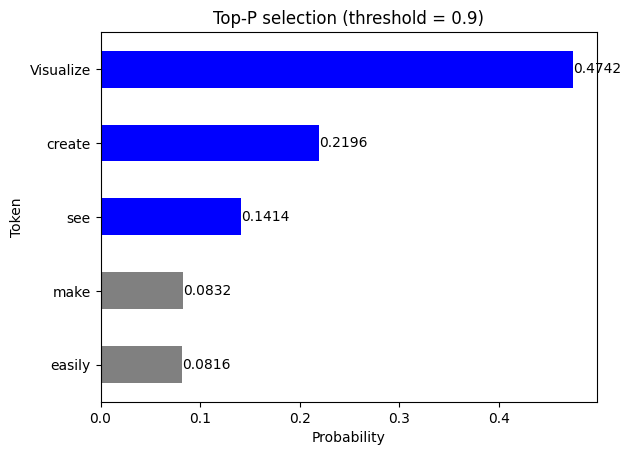

In [168]:
import matplotlib.pyplot as plt

# Highlight the tokens present in top_p_selection
colors = ['gray'] * len(df_sorted)
for idx, token in enumerate(df_sorted['Token']):
    if token in top_p_selection['Token'].values:
        colors[idx] = 'blue'

ax = df_sorted.plot.barh(x='Token', y='Probability', color=colors, xlabel="Probability", legend=False)

for i in ax.containers:
    ax.bar_label(i, fmt='%.4f')

plt.title("Top-P selection (threshold = 0.9)")
ax.invert_yaxis()  # Invert the y-axis
plt.show()

As you can see from the chart, only the most likely words are selected and can be sampled from.
The sampling itself can be done using a numpy weighted choice function.


In [142]:
np.random.choice(df['Token'], p=df['Probability'])

'Visualize'

## Temperature

Now that you've seen how top-P selection works in code. Let's look at how temperature can be used to soften or sharpen the distribution.

A temperature of 1.0 will not change the distribution. Any other value will change the distribution making it more uniform or more peaky.
Higher values soften the curve while lower values sharpen it. To use the temperature, we first divide the logits by the temperature.

In [158]:
temperature = 2.0

In [159]:
df["Scaled Logit"] = df["Logit"] / temperature
df["Scaled probability"] = df["Scaled Logit"].apply(lambda x: math.exp(x) / df["Scaled Logit"].apply(lambda y: math.exp(y)).sum())

Let's perform the top-p selection again, but this time use the probability values after applying the temperature scaling.

In [167]:
# Sort the dataframe by Scaled probability in descending order.
# Then calculate the cumulative scaled probability.
# Finally, select the values with cumulative scaled probability less than or equal to 0.9.
df_sorted_scaled = df.sort_values("Scaled probability", ascending=False)
df_sorted_scaled["Cumulative Scaled Probability"] = df_sorted_scaled["Scaled probability"].cumsum()

# Select the tokens with cumulative scaled probability less than or equal to 0.9
top_p_selection_scaled = df_sorted_scaled[df_sorted_scaled["Cumulative Scaled Probability"] <= 0.9]

In the next cell, I'm rendering a comparison chart to show the difference between the two distributions. The top chart shows the probability distribution without applying the temperature scaling. The bottom chart shows the probability distribution with temperature scaling.
You can tweak the temperature value to see how it affects the distribution.

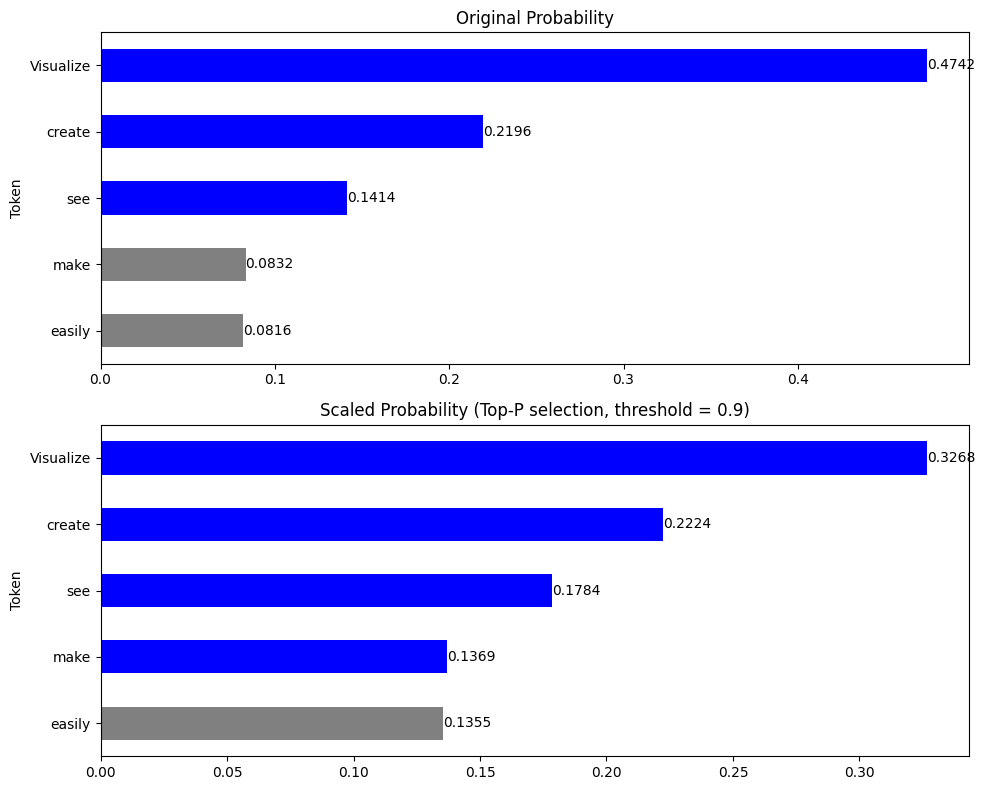

In [172]:
import matplotlib.pyplot as plt

# Highlight the tokens present in top_p_selection_scaled
colors_scaled = ['gray'] * len(df_sorted_scaled)
for idx, token in enumerate(df_sorted_scaled['Token']):
    if token in top_p_selection_scaled['Token'].values:
        colors_scaled[idx] = 'blue'

# Highlight the tokens present in top_p_selection for the original probability
colors_original = ['gray'] * len(df_sorted_scaled)
for idx, token in enumerate(df_sorted_scaled['Token']):
    if token in top_p_selection['Token'].values:
        colors_original[idx] = 'blue'

# Plot the original Probability
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

df_sorted_scaled.plot.barh(x='Token', y='Probability', color=colors_original, ax=ax[0], legend=False)
ax[0].set_title("Original Probability")
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.4f')

# Plot the Scaled probability
df_sorted_scaled.plot.barh(x='Token', y='Scaled probability', color=colors_scaled, ax=ax[1], legend=False)
ax[1].set_title("Scaled Probability (Top-P selection, threshold = 0.9)")
for container in ax[1].containers:
    ax[1].bar_label(container, fmt='%.4f')

ax[0].invert_yaxis()  # Invert the y-axis of the top chart to show the highest probability at the top
ax[1].invert_yaxis()  # Invert the y-axis of the bottom chart to show the highest probability at the top

plt.tight_layout()
plt.show()

Notice how a very high temperature (2.0 for example) boosts the probability of tokens that are unlikely to be selected, while a very low temperature boosts the most-likely tokens instead.